In [1]:
import random
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor

from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.nn import Embedding
from torch.nn import MSELoss
from torch.optim import Adam
from torch.nn.functional import sigmoid
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn.functional import leaky_relu
from torch.nn.functional import relu

import torch_geometric
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.nn import to_hetero

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [3]:
books_df = pd.read_csv("data/Books.csv")
users_df = pd.read_csv("data/Users.csv")
ratings_df = pd.read_csv("data/Ratings.csv")

C:\Users\yasus\AppData\Local\Temp\ipykernel_7700\1815624546.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("data/Books.csv")


In [4]:
indices = []
for i, year in enumerate(books_df["Year-Of-Publication"]):
    try:
        year_num = float(year)
    except:
        indices.append(i)
        print(i, books_df.loc[i, "ISBN"])

209538 078946697X
220731 2070426769
221678 0789466953


In [5]:
books_df.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)

In [6]:
for i in indices:
    books_df.loc[i, "Publisher"] = books_df.loc[i, "Year-Of-Publication"]
    books_df.loc[i, "Year-Of-Publication"] = books_df.loc[i, "Book-Author"]

In [7]:
books_df.loc[209538, "Book-Author"] = books_df.loc[209538, "Book-Title"][81:-1]
books_df.loc[209538, "Book-Title"] = books_df.loc[209538, "Book-Title"][:78]
books_df.loc[220731, "Book-Author"] = books_df.loc[220731, "Book-Title"][40:-1]
books_df.loc[220731, "Book-Title"] = books_df.loc[220731, "Book-Title"][:36]
books_df.loc[221678, "Book-Author"] = books_df.loc[221678, "Book-Title"][93:-1]
books_df.loc[221678, "Book-Title"] = books_df.loc[221678, "Book-Title"][:90]

In [8]:
books_df["Year-Of-Publication"] = books_df["Year-Of-Publication"].astype(int)

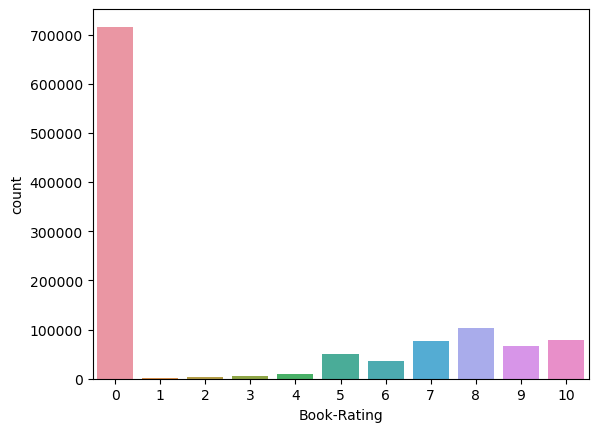

In [9]:
sns.countplot(x="Book-Rating", data=ratings_df)
plt.show()

In [10]:
(ratings_df["Book-Rating"]==1).sum()/len(ratings_df) * 100

0.15394249334655324

In [11]:
ratings_df = ratings_df[ratings_df["Book-Rating"]!=0]

In [12]:
ratings_df.groupby("ISBN").filter(lambda x: len(x) > 20).groupby("ISBN").count()["Book-Rating"]

ISBN
000649840X    41
0007110928    27
0020199600    24
0020442203    29
002542730X    77
              ..
8806142100    23
8807813025    21
8826703132    21
8845205118    21
8873122933    27
Name: Book-Rating, Length: 2034, dtype: int64

In [13]:
ratings_df.groupby("User-ID").filter(lambda x: len(x) > 20).groupby("User-ID").count()["Book-Rating"]

User-ID
183        91
242        33
254        58
392        21
507        37
         ... 
278221     26
278356     36
278418    117
278582     36
278633     44
Name: Book-Rating, Length: 3521, dtype: int64

In [14]:
picked_isbn = ratings_df.groupby("ISBN").filter(lambda x: len(x) > 20).groupby("ISBN").count().index.tolist()
picked_userid = ratings_df.groupby("User-ID").filter(lambda x: len(x) > 20).groupby("User-ID").count().index.tolist()

In [15]:
all_book_isbn = set(books_df["ISBN"]).intersection(set(picked_isbn))
all_user_id = set(users_df["User-ID"]).intersection(set(picked_userid))
ratings_df = ratings_df[ratings_df["ISBN"].isin(all_book_isbn)]
ratings_df = ratings_df[ratings_df["User-ID"].isin(all_user_id)]
books_df = books_df[books_df["ISBN"].isin(all_book_isbn)]
users_df = users_df[users_df["User-ID"].isin(all_user_id)]

In [16]:
tfidf = TfidfVectorizer()
cv = CountVectorizer()
books_df["Book-Author"].fillna("", inplace=True)
books_df["Publisher"].fillna("", inplace=True)
title_matrix = tfidf.fit_transform(books_df["Book-Title"])
author_matrix = cv.fit_transform(books_df["Book-Author"])
publisher_matrix = cv.fit_transform(books_df["Publisher"])
title_matrix.shape, author_matrix.shape, publisher_matrix.shape

((1988, 2562), (1988, 1056), (1988, 261))

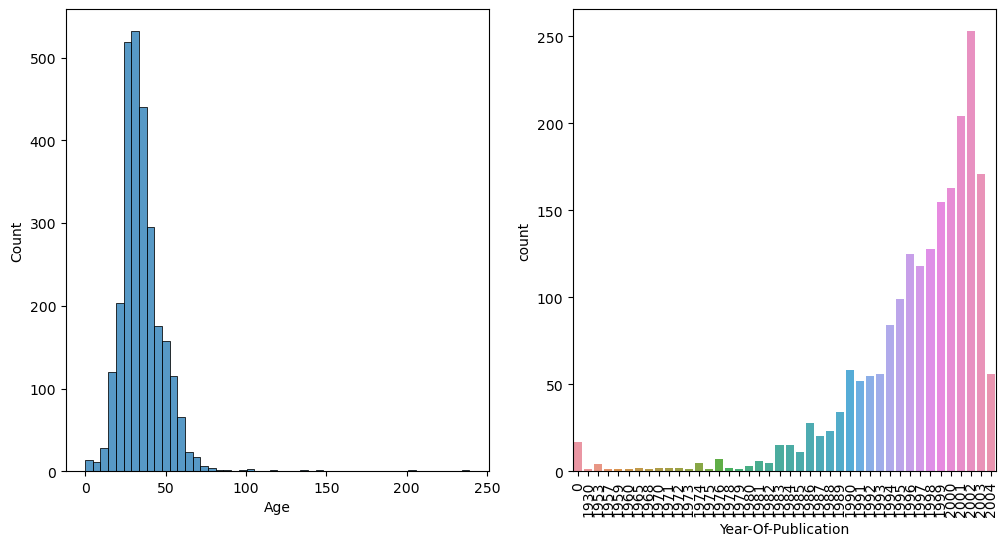

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x="Age", data=users_df, ax=ax[0], bins=50)
cp = sns.countplot(x="Year-Of-Publication", data=books_df, ax=ax[1])
cp.set_xticklabels(cp.get_xticklabels(), rotation=90)
plt.show()

In [18]:
(books_df["Year-Of-Publication"]==0).sum()/len(books_df) * 100

0.8551307847082495

In [19]:
books_df["Year-Of-Publication"] = books_df["Year-Of-Publication"]/books_df["Year-Of-Publication"].max()

In [20]:
cv = CountVectorizer()
location_matrix = cv.fit_transform(users_df["Location"])
location_matrix.shape

(3521, 2209)

In [21]:
users_df["Age"].isna().sum()/len(users_df) * 100

22.209599545583643

In [22]:
users_df["Age"].fillna(0, inplace=True)
users_df["Age"] = users_df["Age"]/users_df["Age"].max()

In [23]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [24]:
books_df = books_df.sort_values(by=["ISBN"]).reset_index(drop=True)
mapping_isbn_2_id = {row[1][0]: row[0] for row in books_df.iterrows()}
mapping_id_2_isbn = {row[0] : row[1][0] for row in books_df.iterrows()}

users_df = users_df.sort_values(by=["User-ID"]).reset_index(drop=True)
mapping_uid_2_id = {row[1][0]: row[0] for row in users_df.iterrows()}
mapping_id_2_uid = {row[0] : row[1][0] for row in users_df.iterrows()}

In [25]:
book_embeddings = []
for book in books_df.iterrows():
    sentence = book[1][1] + " " + book[1][2] + " " + book[1][4]
    book_embeddings.append(model.encode(sentence))

books = np.concatenate([np.array(book_embeddings), books_df["Year-Of-Publication"].to_numpy().reshape(-1, 1)], axis=1)

user_embeddings = []
for user in users_df.iterrows():
    sentence = str(user[1][0]) + " " + user[1][1]
    user_embeddings.append(model.encode(sentence))

users = np.concatenate([np.array(user_embeddings), users_df["Age"].to_numpy().reshape(-1, 1)], axis=1)

In [26]:
book_f_similarity = cosine_similarity(books, books)
user_f_similarity = cosine_similarity(users, users)

In [27]:
ratings_train_df, ratings_test_df = train_test_split(ratings_df, test_size=0.3, random_state=168, stratify=ratings_df["Book-Rating"])
ratings_val_df, ratings_test_df = train_test_split(ratings_test_df, test_size=0.66, random_state=168, stratify=ratings_test_df["Book-Rating"])

In [28]:
ratings_train_df.shape, ratings_val_df.shape, ratings_test_df.shape

((31010, 3), (4518, 3), (8772, 3))

In [29]:
interaction_matrix = np.zeros((len(users_df), len(books_df)))
r, c = [mapping_uid_2_id[user_id] for user_id in ratings_train_df["User-ID"]], [mapping_isbn_2_id[isbn] for isbn in ratings_train_df["ISBN"]]
v = [score for score in ratings_train_df["Book-Rating"]]
interaction_matrix[r, c] = v

In [30]:
def build_feature_matrices(dfs):
    matrices = []
    for df in dfs:
        m = np.zeros((len(df), 513+513+1))
        for i, r in enumerate(df.iterrows()):
            m[i, :513] = users[mapping_uid_2_id[r[1][0]], :]
            m[i, 513:1026] = books[mapping_isbn_2_id[r[1][1]], :]
            m[i, 1026] = r[1][2]
        matrices.append(m)
    return matrices

ratings_train, ratings_val, ratings_test = build_feature_matrices((ratings_train_df, ratings_val_df, ratings_test_df))

In [31]:
def build_edge_indices(dfs):
    sources, destinations, features = [], [], []
    for df in dfs:
        s, d, f = [], [], []
        for r in df.iterrows():
            uid, isbn, rating = r[1][0], r[1][1], r[1][2]
            s.append(mapping_uid_2_id[uid])
            d.append(mapping_isbn_2_id[isbn])
            f.append(rating/10)
        sources.append(s)
        destinations.append(d)
        features.append(f)
    return sources, destinations, features

sources, destinations, features = build_edge_indices((ratings_train_df, ratings_val_df, ratings_test_df))

train_sources, train_destinations, train_features = sources[0], destinations[0], features[0]
val_sources, val_destinations, val_features = sources[1], destinations[1], features[1]
test_sources, test_destinations, test_features = sources[2], destinations[2], features[2]

In [32]:
from torch_geometric.data import HeteroData

graph_data = HeteroData()
graph_data["user"].x = torch.tensor(users, dtype=torch.float32)
graph_data["book"].x = torch.tensor(books, dtype=torch.float32)
graph_data["user", "rates", "book"].edge_index = torch.tensor(np.array([train_sources, train_destinations]), dtype=torch.long)
graph_data["user", "rates", "book"].edge_attr = torch.tensor(np.array(train_features), dtype=torch.long)
graph_data["book", "rated_by", "user"].edge_index = torch.tensor(np.array([train_destinations, train_sources]), dtype=torch.long)
graph_data["book", "rated_by", "user"].edge_attr = torch.tensor(np.array(train_features), dtype=torch.long)
graph_data["user", "rates", "book"].train_edge_index = torch.tensor(np.array([train_sources, train_destinations]), dtype=torch.long)
graph_data["user", "rates", "book"].val_edge_index = torch.tensor(np.array([val_sources, val_destinations]), dtype=torch.long)
graph_data["user", "rates", "book"].test_edge_index = torch.tensor(np.array([test_sources, test_destinations]), dtype=torch.long)
graph_data["user", "rates", "book"].train_ratings = torch.tensor(np.array(train_features), dtype=torch.float)
graph_data["user", "rates", "book"].val_ratings = torch.tensor(np.array(val_features), dtype=torch.float)
graph_data["user", "rates", "book"].test_ratings = torch.tensor(np.array(test_features), dtype=torch.float)

In [33]:
nx_graph = nx.Graph()
nx_graph.add_nodes_from(list(range(len(users))), bipartite=0)
nx_graph.add_nodes_from(list(range(len(users), len(users)+len(books))), bipartite=1)
nx_graph.add_edges_from(np.concatenate([np.array([train_sources + val_sources + test_sources]), np.array([train_destinations + val_destinations + test_destinations]) + len(users)], axis=0).T.tolist())
nx_graph.add_edges_from(np.concatenate([np.array([train_destinations + val_destinations + test_destinations]) + len(users), np.array([train_sources + val_sources + test_sources])], axis=0).T.tolist())

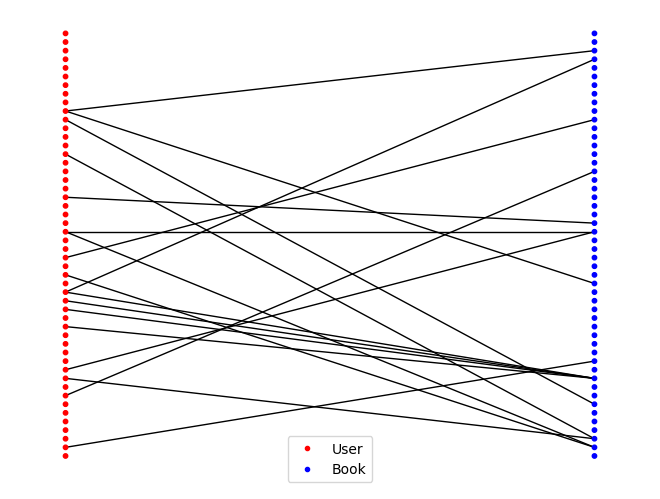

In [34]:
sampled_nodes0 = random.sample(list(range(len(users))), 50)
sampled_nodes1 = random.sample(list(range(len(users), len(users)+len(books))), 50)
nx_sub_graph = nx.subgraph(nx_graph, sampled_nodes0 + sampled_nodes1)
node_color = ['red' if nx_sub_graph.nodes[node]['bipartite'] == 0 else 'blue' for node in nx_sub_graph.nodes()]
pos = nx.bipartite_layout(nx_sub_graph, sampled_nodes0)
nx.draw(nx_sub_graph, pos, with_labels=False, node_color=node_color, node_size=10, edge_color="black")
red_patch = plt.Line2D([], [], color='red', marker='o', markersize=3, linestyle='', label='User')
blue_patch = plt.Line2D([], [], color='blue', marker='o', markersize=3, linestyle='', label='Book')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

Item-Centered Content-Based Filtering

In [35]:
def get_kusers_on_ufeatures(uid, k, sim_mat):
    id = mapping_uid_2_id[uid]
    ids = sim_mat[id, :].argsort()[-2:-(k+2):-1]
    return [mapping_id_2_uid[i] for i in ids]

def get_kbooks_on_bfeatures(isbn, k, sim_mat):
    id = mapping_isbn_2_id[isbn]
    ids = sim_mat[id, :].argsort()[-2:-(k+2):-1]
    return [mapping_id_2_isbn[i] for i in ids]

In [36]:
def score_by_user_sim(uid, isbn, user_sim, inter_mat, k):
    id_u, id_b = mapping_uid_2_id[uid], mapping_isbn_2_id[isbn]
    if inter_mat[id_u, id_b] != 0:
        return inter_mat[id_u, id_b]
    else:
        idx = np.where(inter_mat[:, id_b] !=0)[0]
        if len(idx) == 0:
            return np.median(inter_mat[:, id_b])
        else:
            k = min(k, len(idx))
            return np.mean(inter_mat[idx[user_sim[id_u, idx].argsort()[-1:-(k+1):-1]], id_b])

In [37]:
%%time
min_rmse, optim_k = math.inf, None
for k in range(1, 21):
    item_cbf_val_result = np.array([score_by_user_sim(r[1][0], r[1][1], user_f_similarity, interaction_matrix, k) for r in ratings_val_df.iterrows()])
    item_cbf_val_rmse = ((ratings_val_df["Book-Rating"] - item_cbf_val_result)**2).mean() ** 0.5
    if item_cbf_val_rmse < min_rmse:
        min_rmse = item_cbf_val_rmse
        optim_k = k

print(optim_k, min_rmse)

18 1.7372161680915736
CPU times: total: 13.9 s
Wall time: 14.1 s


In [38]:
%%time
item_cbf_test_result = np.array([score_by_user_sim(r[1][0], r[1][1], user_f_similarity, interaction_matrix, 18) for r in ratings_test_df.iterrows()])
item_cbf_test_rmse = ((ratings_test_df["Book-Rating"] - item_cbf_test_result)**2).mean() ** 0.5
item_cbf_test_rmse

CPU times: total: 1.36 s
Wall time: 1.37 s


1.7355191964381766

User-Centered Content-Based Filtering

In [39]:
def score_by_book_sim(uid, isbn, book_sim, inter_mat, k):
    id_u, id_b = mapping_uid_2_id[uid], mapping_isbn_2_id[isbn]
    if inter_mat[id_u, id_b] != 0:
        return inter_mat[id_u, id_b]
    else:
        idx = np.where(inter_mat[id_u, :] !=0)[0]
        if len(idx) == 0:
            return np.median(inter_mat[id_u, :])
        else:
            k = min(k, len(idx))
            return np.mean(inter_mat[id_u, idx[book_sim[id_b, idx].argsort()[-1:-(k+1):-1]]])

In [40]:
%%time
min_rmse, optim_k = math.inf, None
for k in range(1, 21):
    user_cbf_val_result = np.array([score_by_book_sim(r[1][0], r[1][1], book_f_similarity, interaction_matrix, k) for r in ratings_val_df.iterrows()])
    user_cbf_val_rmse = ((ratings_val_df["Book-Rating"] - user_cbf_val_result)**2).mean() ** 0.5
    if user_cbf_val_rmse < min_rmse:
        min_rmse = user_cbf_val_rmse
        optim_k = k

print(optim_k, min_rmse)

19 1.814410852358627
CPU times: total: 11.5 s
Wall time: 11.6 s


In [41]:
%%time
user_cbf_test_result = np.array([score_by_book_sim(r[1][0], r[1][1], book_f_similarity, interaction_matrix, 19) for r in ratings_test_df.iterrows()])
user_cbf_test_rmse = ((ratings_test_df["Book-Rating"] - user_cbf_test_result)**2).mean() ** 0.5
user_cbf_test_rmse

CPU times: total: 1.11 s
Wall time: 1.12 s


1.7473476001942798

In [42]:
book_cf_similarity = cosine_similarity(interaction_matrix.T, interaction_matrix.T)
user_cf_similarity = cosine_similarity(interaction_matrix, interaction_matrix)

User-User Collaborative Filtering

In [43]:
%%time
min_rmse, optim_k = math.inf, None
for k in range(1, 21):
    user_user_cf_val_result = np.array([score_by_user_sim(r[1][0], r[1][1], user_cf_similarity, interaction_matrix, k) for r in ratings_val_df.iterrows()])
    user_user_cf_val_rmse = ((ratings_val_df["Book-Rating"] - user_user_cf_val_result)**2).mean() ** 0.5
    if user_user_cf_val_rmse < min_rmse:
        min_rmse = user_user_cf_val_rmse
        optim_k = k

print(optim_k, min_rmse)

20 1.73231368194287
CPU times: total: 15.3 s
Wall time: 15.4 s


In [44]:
%%time
user_user_cf_test_result = np.array([score_by_user_sim(r[1][0], r[1][1], user_cf_similarity, interaction_matrix, 20) for r in ratings_test_df.iterrows()])
user_user_cf_test_rmse = ((ratings_test_df["Book-Rating"] - user_user_cf_test_result)**2).mean() ** 0.5
user_user_cf_test_rmse

CPU times: total: 1.53 s
Wall time: 1.55 s


1.7308157043447534

Item-Item Collaborative Filtering

In [45]:
%%time
min_rmse, optim_k = math.inf, None
for k in range(1, 21):
    item_item_cf_val_result = np.array([score_by_book_sim(r[1][0], r[1][1], book_cf_similarity, interaction_matrix, k) for r in ratings_val_df.iterrows()])
    item_item_cf_val_rmse = ((ratings_val_df["Book-Rating"] - item_item_cf_val_result)**2).mean() ** 0.5
    if item_item_cf_val_rmse < min_rmse:
        min_rmse = item_item_cf_val_rmse
        optim_k = k

print(optim_k, min_rmse)

20 1.819794930530574
CPU times: total: 11.7 s
Wall time: 11.8 s


In [46]:
%%time
item_item_cf_test_result = np.array([score_by_book_sim(r[1][0], r[1][1], book_cf_similarity, interaction_matrix, 20) for r in ratings_test_df.iterrows()])
item_item_cf_test_rmse = ((ratings_test_df["Book-Rating"] - item_item_cf_test_result)**2).mean() ** 0.5
item_item_cf_test_rmse

CPU times: total: 1.06 s
Wall time: 1.13 s


1.7457498884960554

In [47]:
ratings_test_df["Book-Rating"].std()

1.7466563513271292

Matrix Factorization Collaborative Filtering

In [48]:
class RatingDatasetMF(Dataset):
    def __init__(self, ratings_df, mapping_uid=mapping_uid_2_id, mapping_isbn=mapping_isbn_2_id):
        self.ratings_df = ratings_df
        self.mapping_uid = mapping_uid
        self.mapping_isbn = mapping_isbn
    
    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        id_b, id_u = self.mapping_isbn[self.ratings_df.iloc[idx, 1]], self.mapping_uid[self.ratings_df.iloc[idx, 0]]
        return [id_u, id_b], self.ratings_df.iloc[idx, 2]/10

In [49]:
class MatrixFactorizer(Module):
    def __init__(self, n_users, n_books, n_latents):
        super().__init__()
        self.user_latents = Embedding(num_embeddings=n_users, embedding_dim=n_latents)
        self.book_latents = Embedding(num_embeddings=n_books, embedding_dim=n_latents)
        self.user_latents.weight.data.uniform_(0, 0.3)
        self.book_latents.weight.data.uniform_(0, 0.3)

    def forward(self, users, books):
        return sigmoid((self.user_latents(users) * self.book_latents(books)).sum(dim=1))

In [50]:
def train_matrix_factorizer(model, dl_train, dl_val, optimizer, criterion = MSELoss(), n_epochs = 10):
    epoch_train_loss, epoch_val_loss = [], []
    for i in range(1, n_epochs+1):
        train_loss, val_loss = [], []
        model.train()
        for (u, b), r in dl_train:
            u, b, r = u.to(device), b.to(device), r.float().to(device)
            optim.zero_grad()
            out = model(u, b)
            loss = criterion(out, r)
            train_loss.append(10*loss.item()**0.5)
            loss.backward()
            optim.step()

        model.eval()
        for (u, b), r in dl_val:
            u, b, r = u.to(device), b.to(device), r.to(device)
            out = model(u, b)
            loss = criterion(out, r)
            val_loss.append(10*loss.item()**0.5)

        epoch_train_loss.append(np.mean(train_loss))
        epoch_val_loss.append(np.mean(val_loss))
        if i == 1 or i % 2 == 0:
            print(f'Epoch: {i}, Train Loss: {epoch_train_loss[-1]}, Validation Loss: {epoch_val_loss[-1]}')

    return epoch_train_loss, epoch_val_loss

In [70]:
%%time
lr = 0.0001
n_latents = 32
N_EPOCHS = 20
mf = MatrixFactorizer(len(users), len(books), n_latents)
mf.to(device)
optim = Adam(mf.parameters(), lr=lr)
dl_train = DataLoader(RatingDatasetMF(ratings_train_df), 32, shuffle=True)
dl_val = DataLoader(RatingDatasetMF(ratings_val_df), 32, shuffle=True)

training_loss, val_loss = train_matrix_factorizer(mf, dl_train, dl_val, optim, MSELoss(), N_EPOCHS)

Epoch: 1, Train Loss: 2.0853570695216743, Validation Loss: 2.042345319673342
Epoch: 2, Train Loss: 1.9853717173885534, Validation Loss: 1.9515026105838824
Epoch: 4, Train Loss: 1.8109780910740891, Validation Loss: 1.8198588792432517
Epoch: 6, Train Loss: 1.6784045534287504, Validation Loss: 1.7239212036702622
Epoch: 8, Train Loss: 1.5823800791891376, Validation Loss: 1.6497826920338403
Epoch: 10, Train Loss: 1.5126897186117416, Validation Loss: 1.6072152063541159
Epoch: 12, Train Loss: 1.4580635885551236, Validation Loss: 1.5790824349756218
Epoch: 14, Train Loss: 1.4194764285674943, Validation Loss: 1.561882454753377
Epoch: 16, Train Loss: 1.3883383906291156, Validation Loss: 1.5537162121896668
Epoch: 18, Train Loss: 1.3629383464691178, Validation Loss: 1.5345290254248931
Epoch: 20, Train Loss: 1.3420333044546033, Validation Loss: 1.5300108789877325
CPU times: total: 18.6 s
Wall time: 1min 43s


In [71]:
def plot_loss_and_acc(training_loss, val_loss, offset = 0):
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    ax.plot(range(offset+1, len(training_loss)+1), training_loss[offset:], '-', linewidth=0.5, label="training")
    ax.plot(range(offset+1, len(val_loss)+1), val_loss[offset:], '-', linewidth=0.5, label="validation")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss / MSE")

In [52]:
%%time
dl_test = DataLoader(RatingDatasetMF(ratings_test_df), len(ratings_test_df))
(u, b), r = next(iter(dl_test))
u, b, r = u.to(device), b.to(device), r.to(device)
mf.eval()
mf_cf_rmse = ((((mf(u,b) * 10) - (r * 10))**2).mean() ** 0.5).item()
mf_cf_rmse

CPU times: total: 562 ms
Wall time: 703 ms


1.551052157661241

Random Forest Regressor

In [53]:
rfr = RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=-1)

In [54]:
%%time
rfr.fit(ratings_train[:, :-1], ratings_train[:, -1])

CPU times: total: 50min 20s
Wall time: 3min 37s


RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=-1)

In [55]:
%%time
rfr_rmse = ((rfr.predict(ratings_test[:, :-1]) - ratings_test[:, -1])**2).mean() ** 0.5
rfr_rmse

CPU times: total: 15.6 ms
Wall time: 63.3 ms


1.5648978567434266

Multiple Layer Perceptron

In [56]:
class RatingDatasetMLP(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings
    
    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.ratings[idx, :-1], self.ratings[idx, -1]/10

In [57]:
class RecommenderMLP(Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(1026, 1024)
        self.dropout1 = Dropout(0.7)
        self.linear2 = Linear(1024, 128)       
        self.linear3 = Linear(128, 1)       

    def forward(self, x):
        out = leaky_relu(self.dropout1(self.linear1(x)))
        out = leaky_relu(self.linear2(out))
        out = sigmoid(self.linear3(out))
        return out

In [58]:
def train_recommender_mlp(model, dl_train, dl_val, optimizer, criterion = MSELoss(), n_epochs = 10):
    epoch_train_loss, epoch_val_loss = [], []
    for i in range(1, N_EPOCHS+1):
        train_loss, val_loss = [], []
        model.train()
        for x, y in dl_train:
            x, y = x.float().to(device), y.float().to(device)
            optim.zero_grad()
            out = model(x).squeeze()
            loss = criterion(out, y)
            train_loss.append(10*loss.item()**0.5)
            loss.backward()
            optim.step()

        model.eval()
        with torch.no_grad():
            for x, y in dl_val:
                x, y = x.float().to(device), y.float().to(device)
                out = model(x).squeeze()
                loss = criterion(out, y)
                val_loss.append(10*loss.item()**0.5)

        epoch_train_loss.append(np.mean(train_loss))
        epoch_val_loss.append(np.mean(val_loss))
        print(f'Epoch: {i}, Train Loss: {epoch_train_loss[-1]}, Validation Loss: {epoch_val_loss[-1]}')

    return epoch_train_loss, epoch_val_loss

In [59]:
%%time
lr = 0.0001
N_EPOCHS = 28

mlp = RecommenderMLP()
mlp.to(device)
optim = Adam(mlp.parameters(), lr=lr)
dl_train = DataLoader(RatingDatasetMLP(ratings_train), 16, shuffle=True)
dl_val = DataLoader(RatingDatasetMLP(ratings_val), 16, shuffle=True)

_, _ = train_recommender_mlp(mlp, dl_train, dl_val, optim, MSELoss(), N_EPOCHS)

Epoch: 1, Train Loss: 1.7422901962262909, Validation Loss: 1.6767415112572852
Epoch: 2, Train Loss: 1.6774666815204957, Validation Loss: 1.6699144048580687
Epoch: 3, Train Loss: 1.6653862820571976, Validation Loss: 1.6677685785853922
Epoch: 4, Train Loss: 1.6564789064418668, Validation Loss: 1.673283361441775
Epoch: 5, Train Loss: 1.6480798999650503, Validation Loss: 1.6581073217612001
Epoch: 6, Train Loss: 1.6420905050838694, Validation Loss: 1.661929618597689
Epoch: 7, Train Loss: 1.6328368346243975, Validation Loss: 1.6489452049520663
Epoch: 8, Train Loss: 1.6257679436048522, Validation Loss: 1.6469726456769773
Epoch: 9, Train Loss: 1.6130131653939266, Validation Loss: 1.6341361288518714
Epoch: 10, Train Loss: 1.6033050219468727, Validation Loss: 1.639919340715519
Epoch: 11, Train Loss: 1.5918411401442385, Validation Loss: 1.6249782426163533
Epoch: 12, Train Loss: 1.5825992169452698, Validation Loss: 1.6140584158660165
Epoch: 13, Train Loss: 1.5663581940077813, Validation Loss: 1.61

In [60]:
%%time
dl_test = DataLoader(RatingDatasetMLP(ratings_test), 8772)
x, y = next(iter(dl_test))
x, y = x.float().to(device), y.float().to(device)
mlp.eval()
with torch.no_grad():
    mlp_rmse = ((((mlp(x).squeeze() * 10) - (y * 10))**2).mean() ** 0.5).item()
    print(mlp_rmse)

1.629041314125061
CPU times: total: 125 ms
Wall time: 141 ms


In [61]:
mlp

RecommenderMLP(
  (linear1): Linear(in_features=1026, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (linear2): Linear(in_features=1024, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)

GAT

In [62]:
from torch_geometric.nn import HANConv

class HANConvRecommender(torch.nn.Module):
    def __init__(self, graph_data):
        super().__init__()
        self.han = HANConv(in_channels=-1, out_channels=512, heads=1, dropout=0.3, metadata=graph_data.metadata())
        self.linear1 = Linear(512, 32)
        self.linear2 = Linear(512, 32)

    def forward(self, x_dict, edge_index_dict):
        h = self.han(x_dict, edge_index_dict)
        u = self.linear1(h["user"]).sigmoid()
        b = self.linear2(h["book"]).sigmoid()
        return u, b

In [63]:
def train_recommender_han(model, graph_data, optimizer, criterion = MSELoss(), n_epochs = 10):
    epoch_train_loss, epoch_val_loss = [], []
    for i in range(1, n_epochs+1):
        model.train()
        optimizer.zero_grad()
        users_latent, books_latent = model(graph_data.x_dict, graph_data.edge_index_dict)
        out = (users_latent[graph_data["user", "rates", "book"]["train_edge_index"][0]] * books_latent[graph_data["user", "rates", "book"]["train_edge_index"][1]]).sum(axis=1).sigmoid()
        loss = criterion(out, graph_data["user", "rates", "book"].train_ratings)
        epoch_train_loss.append(10*loss.item()**0.5)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            users_latent, books_latent = model(graph_data.x_dict, graph_data.edge_index_dict)
            out = (users_latent[graph_data["user", "rates", "book"]["val_edge_index"][0]] * books_latent[graph_data["user", "rates", "book"]["val_edge_index"][1]]).sum(axis=1).sigmoid()
            loss = criterion(out, graph_data["user", "rates", "book"].val_ratings)
            epoch_val_loss.append(10*loss.item()**0.5)

        if i == 1 or i % 200 == 0:
            print(f'Epoch: {i}, Train Loss: {epoch_train_loss[-1]}, Validation Loss: {epoch_val_loss[-1]}')

    return epoch_train_loss, epoch_val_loss

In [73]:
%%time
lr = 0.001
N_EPOCHS = 2000

han = HANConvRecommender(graph_data)
han.to(device)
optim = Adam(han.parameters(), lr=lr)

training_loss, val_loss = train_recommender_han(han, graph_data.to(device), optim, MSELoss(), N_EPOCHS)

Epoch: 1, Train Loss: 2.6995497030033864, Validation Loss: 2.699459589635061
Epoch: 200, Train Loss: 1.7125949321663603, Validation Loss: 1.7241946053207988
Epoch: 400, Train Loss: 1.6068965776620159, Validation Loss: 1.6477772940917528
Epoch: 600, Train Loss: 1.5408383522520166, Validation Loss: 1.6049538155510814
Epoch: 800, Train Loss: 1.5094350771271494, Validation Loss: 1.5780731419267127
Epoch: 1000, Train Loss: 1.4908247037183453, Validation Loss: 1.567142087805205
Epoch: 1200, Train Loss: 1.4704633367842335, Validation Loss: 1.5584250002647162
Epoch: 1400, Train Loss: 1.46015217016639, Validation Loss: 1.5570500217192378
Epoch: 1600, Train Loss: 1.4472673701843364, Validation Loss: 1.5557526696708035
Epoch: 1800, Train Loss: 1.4452246690817347, Validation Loss: 1.555027318362624
Epoch: 2000, Train Loss: 1.4351144126271964, Validation Loss: 1.5516922410539216
CPU times: total: 3.72 s
Wall time: 32.6 s


In [76]:
han

HANConvRecommender(
  (han): HANConv(512, heads=1)
  (linear1): Linear(in_features=512, out_features=32, bias=True)
  (linear2): Linear(in_features=512, out_features=32, bias=True)
)

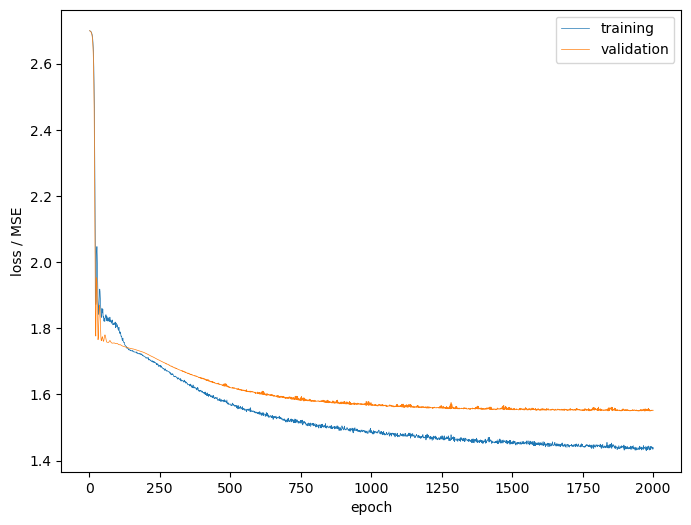

In [75]:
plot_loss_and_acc(training_loss, val_loss)

In [65]:
%%time
han.eval()
with torch.no_grad():
    users_latent, books_latent = han(graph_data.x_dict, graph_data.edge_index_dict)
    out = (users_latent[graph_data["user", "rates", "book"]["test_edge_index"][0]] * books_latent[graph_data["user", "rates", "book"]["test_edge_index"][1]]).sum(axis=1).sigmoid()
    loss = ((out - graph_data["user", "rates", "book"].test_ratings)**2).mean()
    print(10*loss.item()**0.5)

1.5468253455236156
CPU times: total: 0 ns
Wall time: 0 ns


In [109]:
from sklearn.cluster import DBSCAN
rr = np.concatenate([ratings_train, ratings_val, ratings_test], axis=0)
dbs = DBSCAN(eps=0.30, metric='cosine')
dbs.fit(rr[:, :-1])

DBSCAN(eps=0.31, metric='cosine')

In [98]:
np.sum(dbs.labels_==-1), set(dbs.labels_)

(2, {-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})

In [100]:
for i in range(11):
    print(np.sum(dbs.labels_==i))

44109
12
15
26
37
27
11
35
6
16
4
